In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import linalg as LA
plt.style.use("ggplot")

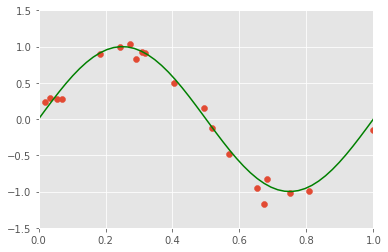

In [2]:
N = 20
train_X = np.random.uniform(0, 1, N)
train_t = np.sin(2 * np.pi * train_X) + np.random.normal(0, 0.1, N)
plt.scatter(train_X, train_t)
plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c="g")
plt.xlim(0,1)
plt.ylim(-1.5, 1.5)
plt.show()

特徴量空間

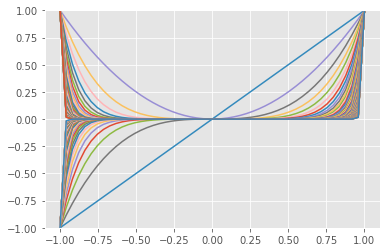

In [3]:
M = 100
def phi(x):
  return x ** np.arange(0,M)

X = np.linspace(-1,1)
Y = np.array([phi(x) for x in X]) #(50, M)
plt.ylim(-1,1)
for i in range(M):
  plt.plot(X,Y.T[i])

RVMの制限としてカーネルをSVMの双対表現に合わせる

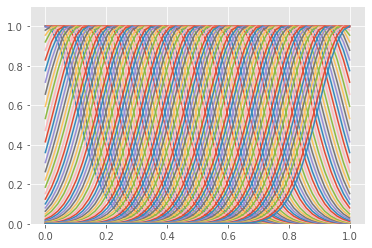

In [4]:
M = 100
def phi(x):
  h = 0.1
  return np.append(1, np.exp(-(x - np.linspace(0,1,M-1))**2/(2*h**2) ))

X = np.linspace(0,1)
plt.ylim(0,1.1)
Y = np.array([phi(x) for x in X])
for i in range(M):
  plt.plot(X, Y.T[i])

In [5]:
Phi = np.array([phi(x) for x in train_X]) #(N, M)
Phi.shape

(20, 100)

In [6]:
A = np.diag(np.ones(M) * 10)
beta = 1

S = LA.inv( A + beta * Phi.T@Phi) #(M,M)
m = beta * S @ Phi.T @ train_t

for i in range(100):
  gamma = np.ones(M) - np.diag(A) * np.diag(S)
  A_flat = gamma/ m **2
  
  A_flat[A_flat > 1e5] = 1e5

  new_A = np.diag(A_flat)
  new_beta = (N - gamma.sum()) / (train_t - Phi@m).T@(train_t - Phi@m)

  S = LA.inv( new_A + new_beta * Phi.T@Phi) #(M,M)
  m = new_beta * S @ Phi.T @ train_t

  if LA.norm(new_A - A) / LA.norm(A) < 0.01 and LA.norm(new_beta - beta)/LA.norm(beta) < 0.01:
    break
  
  beta = new_beta
  A = new_A

m[abs(m) < 1e-2] = 0

過学習が起きていない

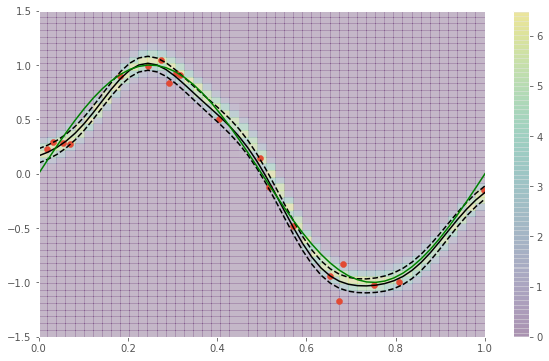

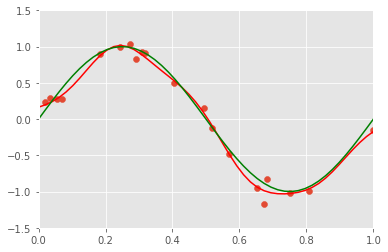

In [8]:
import scipy.stats as stats
def sigma(x):
    return np.sqrt(1 / beta + phi(x).T.dot(S).dot(phi(x)))
 
def model_y(x):
    return m.dot(phi(x))
 
def norm(x, t):
    return stats.norm(model_y(x), sigma(x)).pdf(t)
 
#図示
x_, y_ = np.meshgrid(np.linspace(0,1), np.linspace(-1.5, 1.5))
Z = np.vectorize(norm)(x_,y_)
 
plt.figure(figsize=(10,6))
plt.pcolor(x_, y_, Z, alpha = 0.2)
plt.colorbar()
plt.scatter(train_X, train_t)
 
#予測分布の平均と1シグマ区間
x = np.linspace(0,1)
y = np.vectorize(model_y)(x)
plt.plot(x, y, c = "k")
plt.plot(x, y+np.vectorize(sigma)(x), c = "k", linestyle='dashed')
plt.plot(x, y-np.vectorize(sigma)(x), c = "k", linestyle='dashed')
 
plt.xlim(0, 1)
plt.ylim(-1.5, 1.5)
 
#本物の分布
plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g")
plt.show()
 
#データ点
plt.scatter(train_X, train_t)
 
#予測曲線
x = np.linspace(0,1)
y = np.vectorize(model_y)(x)
plt.plot(x, y, c = "r")
 
plt.xlim(0, 1)
plt.ylim(-1.5, 1.5)
 
#本物の分布
plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g")
plt.show()

ガウスカーネルを利用する

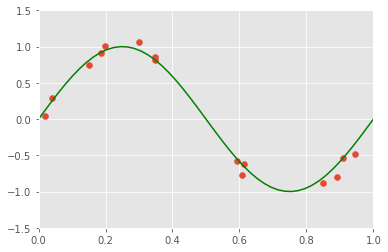

In [9]:
N = 15
 
train_X = np.random.uniform(0, 1, N)
train_t = np.sin(2 * np.pi * train_X) + np.random.normal(0, 0.1, N)
plt.scatter(train_X, train_t)
plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g")  #y = sin(2πx)
plt.xlim(0, 1)
plt.ylim(-1.5, 1.5)
plt.show()

In [12]:
def k(x_, x):
  return np.exp(- 10 * (x_ - x) ** 2)

Phi = np.ones([N,N])
for i in range(N):
  Phi[i,:] = np.array([k(x_, train_X[i]) for x_ in train_X])

A = np.diag(np.ones(N) * 10)
beta = 1
# y(x)の事後分布
S = LA.inv(A + beta*Phi.T@Phi)
m = beta*S@Phi.T@train_t
for i in range(100):
  gamma = np.ones(N) - np.diag(A)*np.diag(S)
  A_flat = gamma / m**2

  A_flat[A_flat > 1e5] = 1e5
  new_A = np.diag(A_flat)
  new_beta = (N - gamma.sum())/(train_t - Phi@m)@(train_t - Phi@m)

  S = LA.inv(new_A + new_beta*Phi.T@Phi)
  m = new_beta * S @ Phi.T @ train_t

  if LA.norm(new_A - A) / LA.norm(A) < 0.01 and LA.norm(new_beta - beta) / LA.norm(beta) < 0.01:
        break
 
  beta = new_beta
  A = new_A

m[abs(m) < 1e-2] = 0
print(f"iter:{i}")
print(m)

iter:13
[-0.07553779 -1.23376844  0.          0.          0.          0.
  0.         -0.13256967  1.81850954  0.          0.          0.
  0.         -0.63805041  0.        ]


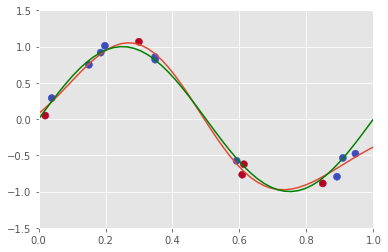

In [15]:
def model_y(x):
  y = m.dot(k(train_X,x))
  return y

X = np.linspace(0,1)
Y = np.vectorize(model_y)(X)

c = m != 0
plt.scatter(train_X, train_t, c=c, s=50, cmap=cm.coolwarm)
plt.plot(X,Y)
plt.xlim(0,1)
plt.ylim(-1.5, 1.5)
plt.plot(x, np.sin(2*np.pi*x), c="g")
plt.show()

In [19]:
def sigma(x):
  return np.sqrt(1/beta + k(train_X, x)@S@k(train_X, x))

def norm(x,t):
  return stats.norm(model_y(x), sigma(x)).pdf(t)

def graph(f):
    x_, y_ = np.meshgrid(np.linspace(0,1, 100), np.linspace(-1.5, 1.5, 100))
    Z = np.vectorize(f)(x_,y_)
 
    plt.figure(figsize=(10,6))
    plt.pcolor(x_, y_, Z, alpha = 0.2)
    plt.colorbar()
    c = m != 0
    plt.scatter(train_X, train_t, c = c, s=50, cmap=cm.coolwarm)
 
    #予測分布の平均と1シグマ区間
    x = np.linspace(0,1)
    y = np.vectorize(model_y)(x)
    plt.plot(x, y, c = "k")
    plt.plot(x, y+np.vectorize(sigma)(x), c = "k", linestyle='dashed')
    plt.plot(x, y-np.vectorize(sigma)(x), c = "k", linestyle='dashed')
 
    plt.xlim(0, 1)
    plt.ylim(-1.5, 1.5)
 
    #本物の分布
    plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g")
    plt.show()

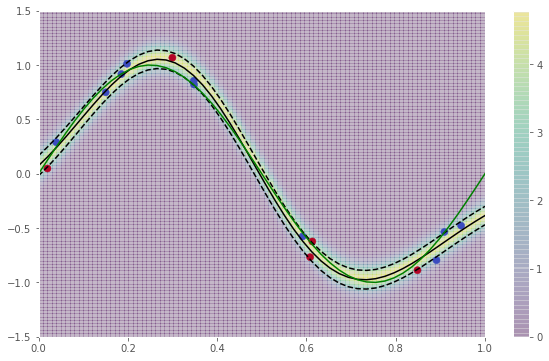

In [20]:
graph(norm)